# Final Project - Part B - Classifier

## Loading Data

In [1]:
import pandas as pd

df = pd.read_csv('songs.csv')#, index_col=['headline'])
lyrics= df['lyrics']
lyrics.head(3)

0    one  two  three  four   well  she was just sev...
1    the world is treating me bad misery  i'm the k...
2    anna you come and ask me  girl to set you free...
Name: lyrics, dtype: object

## Prepare Vocabulary

After loading the data we would like to builde a vocabulary. we will remove the stop word for saving only meaningful words. and use Stemming to reduce inflected words

In [2]:
import nltk
from nltk.corpus import stopwords 

stop_words=stopwords.words("english") 
song_lyrics=lyrics


def impotenr_words (song_lyrics):
    #remove stop words
    words = nltk.word_tokenize(song_lyrics)
    words = [w for w in words if not w in stopwords.words("english")]
    # Stemming
    porter = nltk.PorterStemmer()
    #lancaster = nltk.LancasterStemmer()
    words=[porter.stem(w) for w in words]   
    #print len([lancaster.stem(w) for w in words]) 
    return  " ".join( words )
song_lyrics=map (impotenr_words,song_lyrics)

we will create bag of words of all words

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the "CountVectorizer"  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                              ) 

train_data_features = vectorizer.fit_transform(song_lyrics)
train_data_features = train_data_features.toarray()
vocab = vectorizer.get_feature_names()

#check Vocabelry size
print ("Vocabulary size is: "+str(len(vocab)))
                 
import numpy as np

# Sum up the counts of each vocabulary word
dist = np.sum(train_data_features, axis=0)

#print the lowst 10
for tag, count in sorted(zip(vocab, dist) ,key=lambda song: song[1])[0:10]:
    print(count, tag)      

Vocabulary size is: 8606
(1, u'12x')
(1, u'151')
(1, u'175')
(1, u'19')
(1, u'1998')
(1, u'23')
(1, u'28')
(1, u'29')
(1, u'2nd')
(1, u'2paclyps')


we can see there are 8606 words in our vocubelry. many of them appear once so lets take the top 10% using the max_features atribbute

In [4]:
# Initialize the "CountVectorizer"  using max_features as 10% of all features 
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features =int (len(vocab)*0.1) 
                              ) 

train_data_features = vectorizer.fit_transform(song_lyrics)


train_data_features = train_data_features.toarray() 

vocab = vectorizer.get_feature_names()
#check Vocabelry size
print ("new vocabulary size is: "+str(len(vocab)))

new vocabulary size is: 860


## Train Model

### Random Forst 1

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
import numpy as np
#cross valdition wirh RandomForestClassifier
cross_val1=(cross_val_score(RandomForestClassifier(n_estimators = 100)  , train_data_features, df["singer"],cv=10))  
print (cross_val1)


[ 0.84745763  0.74576271  0.89830508  0.89655172  0.92982456  0.98245614
  0.89285714  0.85714286  0.875       0.94642857]


this  results are not bad. but we mybe choose the top 10% words is not the best way to choose the vocabulery size.Mybe take the words that apeer in at least 10% of the songs is better way to calsffier singer lyrics .

We will try choose the vocabulry that way using the min_df feature

### Random Forst 2

In [7]:
# Initialize the "CountVectorizer"  using max_features as 10% of all features 
vectorizer2 = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             min_df  =int (len(song_lyrics)*0.10) 
                              ) 

train_data_features2 = vectorizer2.fit_transform(song_lyrics)


train_data_features2 = train_data_features2.toarray() 

vocab = vectorizer2.get_feature_names()
#check Vocabelry size
print ("new vocabulary size is: "+str(len(vocab)))
#cross valdition wirh RandomForestClassifier
cross_val2=(cross_val_score(RandomForestClassifier(n_estimators = 100)  , train_data_features2, df["singer"],cv=10))  

new vocabulary size is: 186


## Tf_Idf 

we will do also model based on tf-idf

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(analyzer = "word",tokenizer = None, ngram_range=(1,3), max_features = 200, stop_words = None,min_df=1, use_idf=True)
tfidf_matrix = tfidfvectorizer.fit_transform(song_lyrics)
#cross valdition wirh RandomForestClassifier
cross_val3=(cross_val_score(RandomForestClassifier(n_estimators = 100)  , tfidf_matrix, df["singer"],cv=10))  


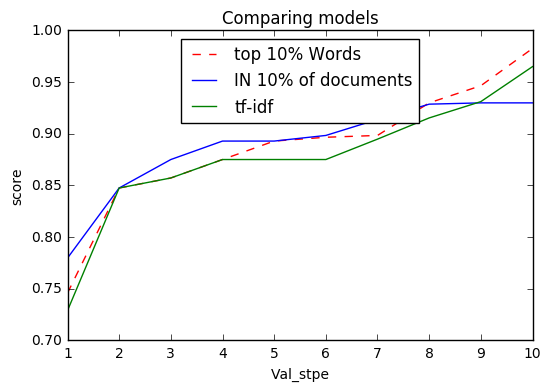

In [9]:
import matplotlib.pyplot as plt

t = np.arange(1, 11, 1)
plt.plot(t,sorted(cross_val1) ,'r--',label='top 10% Words' )
plt.plot(t,sorted(cross_val2), 'b',label='IN 10% of documents')
plt.plot(t, sorted(cross_val3), 'g',label='tf-idf')
plt.ylabel('score')
plt.xlabel('Val_stpe')
plt.title('Comparing models')
plt.legend(loc='upper center')
plt.show()

In [10]:
print ("top 10% Words mean score=" + str(cross_val1.mean()))
print ("IN 10% of documents mean score=" + str(cross_val2.mean()))
print ("tf-idf mean score mean score=" + str(cross_val3.mean()))

top 10% Words mean score=0.887178642105
IN 10% of documents mean score=0.888815166935
tf-idf mean score mean score=0.876435188644


From comparing the three models we can see that all tree give almost the same result so we will choose the "IN 10% of documents" because it mean score is a little bit better and it has the smalles number of features.

We will split the data set for train and test and train the modle

In [11]:
#split to train & test
msk = np.random.rand(len(song_lyrics)) < 0.8
train_x = train_data_features2[msk]
test_x = train_data_features2[~msk]
train_y = df.loc[msk,"singer"]
test_y = df.loc[~msk,"singer"]

# Initialize a Random Forest classifier with 100 trees
forest = RandomForestClassifier(n_estimators = 100) 

# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
#
# This may take a few minutes to run
forest = forest.fit( train_x, train_y )

# Evaluate accuracy best on the test set
forest.score(test_x,test_y)

0.90163934426229508

we have 90% accuracy for this tarin\test set  and 89% with the cross validtion not bad result!